* Project name - Doctor T

* Used CNN architecture - MobileNet

* Author - Mayurathan

In [ ]:
# Mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing libraries
import tensorflow as tf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import os
for dirname, _, filenames in os.walk('/content/drive/MyDrive/Dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    break

In [ ]:
root_dir = "/content/drive/MyDrive/Dataset/train"
os.listdir(root_dir)

['Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___healthy']

In [ ]:
# hyper parameters
batch_size = 16
img_height, img_width=224,224
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    root_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    root_dir, # same directory as training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
validation_generator[0][1][1]

array([1., 0., 0.], dtype=float32)

In [ ]:
def show(img, title=None, fig_size=(5, 5)):
    fig = plt.figure(figsize=fig_size)
    if title is not None:
        plt.title(title)
    plt.imshow(img)
    plt.axis("off")
    plt.show()

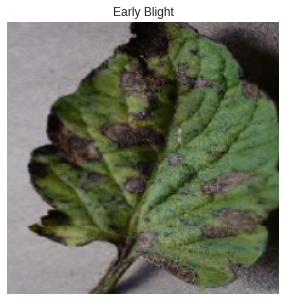

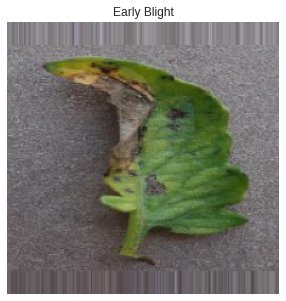

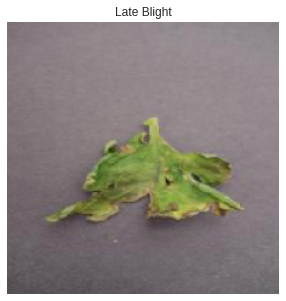

In [ ]:
import cv2
plt.style.use('seaborn-whitegrid')
for i in range(3):
    labels = ["Early Blight", "Late Blight", "Healthy"]
    img = validation_generator[0][0][i]
    lbl = labels[np.argmax(validation_generator[0][1][i])]
    
    img = cv2.resize(img, (img_height, img_width))
    img = img.reshape(img_height, img_width, 3)
    show(img, title=lbl)

In [ ]:
from keras.applications.mobilenet import preprocess_input, MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from keras.models import Model

img_input = Input(shape=(img_height, img_width, 3), name = 'grayscale_input_layer')
# x = Conv2D(3, (3,3),  padding= 'same', name = 'grayscale_RGB_layer')(img_input)
mobilenet = MobileNet(input_shape = (img_height, img_width, 3), include_top = False, weights = 'imagenet')
mobilenet.layers.pop()  # Remove classification layer

for layer in mobilenet.layers:
    layer.trainable = False
    if type(layer) == 'BatchNormalization':
        layer.momentum = 1.0

mobilenet = mobilenet(img_input)
output = mobilenet
output = GlobalAveragePooling2D()(output)

output = Dropout(0.5)(output)
output = Dense(3, activation="softmax")(output) 
model = Model(inputs=[img_input], outputs=[output], name='embedding_model')

In [ ]:
lr=1e-03
epochs=15

opt = Adam(lr=lr, decay=lr / epochs)

# compile
model.compile(loss="categorical_crossentropy", optimizer=opt,	metrics=["accuracy"])

# train
history=model.fit(
	train_generator,
	steps_per_epoch=len(train_generator),
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
	epochs=epochs,
  verbose=1,
	workers=32)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/15
150/150 [==============================] - 38s 232ms/step - loss: 0.7650 - accuracy: 0.6904 - val_loss: 0.2455 - val_accuracy: 0.9317
Epoch 2/15
150/150 [==============================] - 36s 228ms/step - loss: 0.3624 - accuracy: 0.8612 - val_loss: 0.1764 - val_accuracy: 0.9450
Epoch 3/15
150/150 [==============================] - 36s 229ms/step - loss: 0.2687 - accuracy: 0.8938 - val_loss: 0.1340 - val_accuracy: 0.9667
Epoch 4/15
150/150 [==============================] - 36s 228ms/step - loss: 0.2489 - accuracy: 0.9000 - val_loss: 0.1196 - val_accuracy: 0.9617
Epoch 5/15
150/150 [==============================] - 36s 228ms/step - loss: 0.2151 - accuracy: 0.9108 - val_loss: 0.1210 - val_accuracy: 0.9550
Epoch 6/15
150/150 [==============================] - 36s 227ms/step - loss: 0.2174 - accuracy: 0.9146 - val_loss: 0.1099 - val_accuracy: 0.9633
Epoch 7/15
150/150 [==============================] - 36s 226ms/step - loss: 0.2060 - accuracy: 0.9146 - val_loss: 0.1000 - val_ac

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


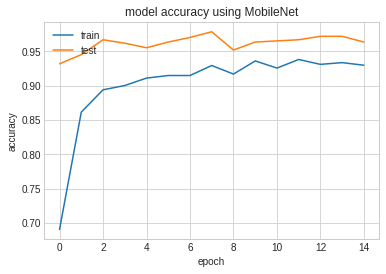

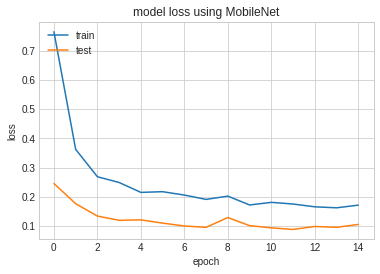

In [ ]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy using MobileNet')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss using MobileNet')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#save architecture as json and weight as h5
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")


In [ ]:
# Convert the h5 file to tflite file

import traceback

from os.path import splitext, basename

mod_path = "/content/model.h5"

def load_model(path,custom_objects={},verbose=0):
    #from tf.keras.models import model_from_json

    path = splitext(path)[0]
    with open('%s.json' % path,'r') as json_file:
        model_json = json_file.read()
    model = tf.keras.models.model_from_json(model_json, custom_objects=custom_objects)
    model.load_weights('%s.h5' % path)
    if verbose: print('Loaded from %s' % path)
    return model

keras_mod = load_model(mod_path)

converter = tf.lite.TFLiteConverter.from_keras_model(keras_mod)
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpi7cl9b11/assets


INFO:tensorflow:Assets written to: /tmp/tmpi7cl9b11/assets


In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'